# MSDS 453: Research/Programming Assignment #4 (Final Assignment): Part 3

**Management Problem**

I will be exploring Twitter sentiment analysis for my final NLP research/programming assignment. This is a challenging yet important field of study for organizations in both public and private sectors. Twitter is a popular platform where entities at all levels—governments, businesses, country leaders, celebrities, and even the average person—express their opinions. The content of such tweets could represent a country's official policy or collectively, a country's public sentiment toward a particular issue. Given the massive volume of tweets generated each day—on average, [6,000 tweets are posted on Twitter every second](https://www.internetlivestats.com/twitter-statistics/)—there is immense value in being able quickly and accurately determine such sentiment values (e.g., positive or negative). We can use a combination of NLP and machine learning to accomplish this. 

**Corpus Description**

The corpus I will use is Stanford University's [Sentiment140](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip). The dataset is a CSV file consisting of 1.6 million English-language tweets. The tweets are annotated using six attributes: 1. polarity of the tweet (0 = negative, 2 = neutral, 4 = positive); 2. ID; 3. date; 4. query; 5. username; 6. text. For this project, I will use the polarity and text values to build a classification model that could take any given tweet and determine the most probable sentiment value.

**NLP Methods**

Given the massive number of documents in the corpus (one tweet = one document), it will be important to ensure the data, particularly each tweet's text, is cleaned and tokenized properly for any follow-on modeling/classification tasks. Regular expressions will be useful in handling any emoticons or special characters (e.g., @ symbols and hashtags). As part of the data exploration step, I could generate histograms and word clouds using various aspects of the tweets (e.g., text content, null values, positive/negative/neutral breakdown, date distribution, etc.) to gain a broad understanding of both qualitative and quantitative aspects of the corpus. 

With regard to vectorization, I plan to use the methods covered in class thus far, including analyst judgment, TF-IDF, and Doc2vec. Since there are 1.6 million documents, it would be important for me to limit the vocabulary by tuning the vectorizer hyperparameters (e.g., max_features, max_df) and exploring dimensionality reduction techniques, such as PCA. Finally, I will evaluate the vectors using various classifiers to ensure I have the optimal number of features in training the classification model. I plan to experiment with both traditional classifiers (e.g., logistic regression, random forest, and ensemble methods) and neural networks.

The neural net classification models will be built using Keras, primarily for its relatively easy, flexible, and user-friendly syntax. The evaluation method to determine the best classification model could consist of a simple training-and-test regimen within a crossed experimental design. Each model in the experiment would be comparable in terms of vocabulary size and word embeddings. I will likely build the models using the Keras Sequential model that takes the input data (i.e., processed tweet text vectors) through the following layers: a convolutional layer (Conv1D), max pooling (MaxPooling1D) for spatial downsampling, and finally a LSTM to help preserve the learning and error through the various layers. I plan to also plot the learning curves in terms of accuracy for both train/validation datasets to provide a visual representation of the models' performances.


## NOTES

This notebook is a continuation (part 3 of 3) of MSDS 453 Final Assignment. You need access to the clean_tweets.csv file in order to run the following code.

In this notebook, I use observations and findings from parts 1 and 2 to train four neural network models. The objective is to see if I can train a neural network model that could perform better than traditional machine learning models, namely logistic regrssion using a trigram TF-IDF vectorization.

In [ ]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import re
import os

from google.colab import files
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import utils
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction import text
from time import time

from pprint import pprint
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
import os
os.chdir('/content/drive/My Drive/MSDS 453/Assignment 4')

# Now the directory 'abc' is the current working directory.
!ls

auc-roc_NNvsCNN.png
clean_tweets.csv
clf_compare_accuracy_summary.csv
cvec_tfidf_accuracy_summary.csv
d2v_cvec_tfidf_accuracy_summary.csv
d2v_model_dbow.doc2vec
d2v_model_dbow.doc2vec.docvecs.vectors_docs.npy
d2v_model_dbow.doc2vec.trainables.syn1neg.npy
d2v_model_dbow.doc2vec.wv.vectors.npy
Data
dbow_cvec_tfidf_accuracy_summary.csv
dmm_dbow_cvec_tfidf_accuracy_summary.csv
final_eval_summary.csv
final_eval_summary.gsheet
model_cnn1.h5
model_cnn2a.h5
model_cnn2.h5
model_nn1_acc_curves.png
model_nn1.h5
model_nn2_acc_curves.png
model_nn2.h5
ngram_accuracy_comparison_plot.png
nn2_accuracy_summary.csv
nn_accuracy_summary.csv
Paper


In [ ]:
df = pd.read_csv('clean_tweets.csv', index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


## Model Training Prep

Train / Dev / Test Split

Given the 1.5 million+ size of the dataset, I will split the data into training, validation, and test data.

In [ ]:
x = df.text
y = df.target

In [ ]:
SEED = 5000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [ ]:
print("Train set has total {0} entries with {1:.2f}% negative tweets, {2:.2f}% positive tweets.".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative tweets, {2:.2f}% positive tweets.".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative tweets, {2:.2f}% positive tweets.".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564120 entries with 50.02% negative tweets, 49.98% positive tweets.
Validation set has total 15960 entries with 49.18% negative tweets, 50.82% positive tweets.
Test set has total 15961 entries with 49.86% negative tweets, 50.14% positive tweets.


## TF-IDF + Logistic Regression (Trigram)

In part 2, I discovered that a logistic regression model with a trigram TF-IDF vectorization resulted in the highest accuracy (higher than the Doc2vec+DBOW model or Doc2vec+DMM models). I will generate the accuracy scores for both the train and validation data as reference points for the subsequent neural network model.

In [ ]:
tfidf_vector = TfidfVectorizer(max_features=80000,ngram_range=(1, 3))
tfidf_vector.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=80000,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
x_train_tfidf = tfidf_vector.transform(x_train)

In [ ]:
x_validation_tfidf = tfidf_vector.transform(x_validation).toarray()

In [ ]:
%%time
lr_clf = LogisticRegression()
lr_clf.fit(x_train_tfidf, y_train)

CPU times: user 57.9 s, sys: 1min 13s, total: 2min 11s
Wall time: 43.2 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
lr_clf.score(x_validation_tfidf, y_validation)

0.831265664160401

In [ ]:
lr_clf.score(x_train_tfidf, y_train)

0.8356705367874587

**TF-IDF + Logistic Regression Accuracy Results:**
*  Training Accuracy: 83.57%
*  Validation Accuracy: 83.13%

## Keras NN Models

In [ ]:
seed = 50
np.random.seed(seed)
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense

Upgrade to TensorFlow 2.x:

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/migrate.ipynb

In [ ]:
# from __future__ import absolute_import, division, print_function, unicode_literals
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
# import tensorflow as tf


# import tensorflow_datasets as tfds

Keras NN model cannot handle sparse matrix directly. The data has to be dense array or matrix, but transforming the whole training data Tfidf vectors of 1.5 million+ to dense array is too big for my system to handle. As a workaround, we can use the following function, which generates iterable generator object so that it can be fed to NN model. Note: the output should be a generator class object rather than arrays, this can be achieved by using "yield" instead of "return".

In [ ]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0

### NN Model 1 (NN-1)

In [ ]:
%%time
model_nn1 = Sequential()
model_nn1.add(Dense(64, kernel_initializer ='uniform', activation='relu', input_dim=80000))
model_nn1.add(Dense(1, kernel_initializer ='uniform', activation='sigmoid'))

# compile model using accuracy to measure model performance
model_nn1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# define the checkpoint
filepath = "model_nn1.h5"
nn1_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [nn1_checkpoint]

# train the model
history_nn1 = model_nn1.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32, callbacks=callbacks_list)

# save model
model.save('model_nn1.h5') 

# evaluate model on train & validation sets
scores = model_nn1.evaluate(x_train_tfidf, y_train)
print("\n%s: %.2f%%" % (model_nn1.metrics_names[1], scores[1]*100), "for training set\n")
train_acc_model_nn1 = scores[1]

scores_val = model_nn1.evaluate(x_validation_tfidf, y_validation)
print("\n%s: %.2f%%" % (model_nn1.metrics_names[1], scores_val[1]*100), "for validation set")
test_acc_model_nn1 = scores_val[1]

Epoch 1/2
48879/48878 [==============================] - 2661s 54ms/step - loss: 0.4087 - acc: 0.8137 - val_loss: 0.3890 - val_acc: 0.8294
Epoch 2/2
1564120/1564120 [==============================] - 579s 370us/step

acc: 84.48% for training set

15960/15960 [==============================] - 8s 506us/step

acc: 83.08% for validation set
CPU times: user 4h 40min 32s, sys: 18min 37s, total: 4h 59min 9s
Wall time: 1h 37min 33s


#### Train Model

In [ ]:
%%time
model_nn1 = Sequential()
model_nn1.add(Dense(64, kernel_initializer ='uniform', activation='relu', input_dim=80000))
model_nn1.add(Dense(1, kernel_initializer ='uniform', activation='sigmoid'))

# compile model using accuracy to measure model performance
model_nn1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# define checkpoint to save model after each epoch
filepath = "model_nn1.h5"
nn1_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)

# train model
history_nn1 = model_nn1.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32, callbacks=[nn1_checkpoint])

Epoch 1/2
48879/48878 [==============================] - 2409s 49ms/step - loss: 0.4089 - acc: 0.8137 - val_loss: 0.3890 - val_acc: 0.8296

Epoch 00001: val_acc improved from -inf to 0.82964, saving model to model_nn1.h5
Epoch 2/2
43979/48878 [=========================>....] - ETA: 3:57 - loss: 0.3762 - acc: 0.8327Buffered data was truncated after reaching the output size limit.

#### Evaluate Model

In [ ]:
# load model
model_nn1_load = load_model("model_nn1.h5")

# evaluate model on train & validation sets
scores = model_nn1_load.evaluate(x_train_tfidf, y_train)
print("\n%s: %.2f%%" % (model_nn1_load.metrics_names[1], scores[1]*100), "for training set\n")
train_acc_model_nn1 = scores[1]

scores_val = model_nn1_load.evaluate(x_validation_tfidf, y_validation)
print("\n%s: %.2f%%" % (model_nn1_load.metrics_names[1], scores_val[1]*100), "for validation set")
val_acc_model_nn1 = scores_val[1]

1564120/1564120 [==============================] - 756s 483us/step

acc: 84.42% for training set

15960/15960 [==============================] - 9s 551us/step

acc: 82.98% for validation set


#### Plot Accuracy Curves

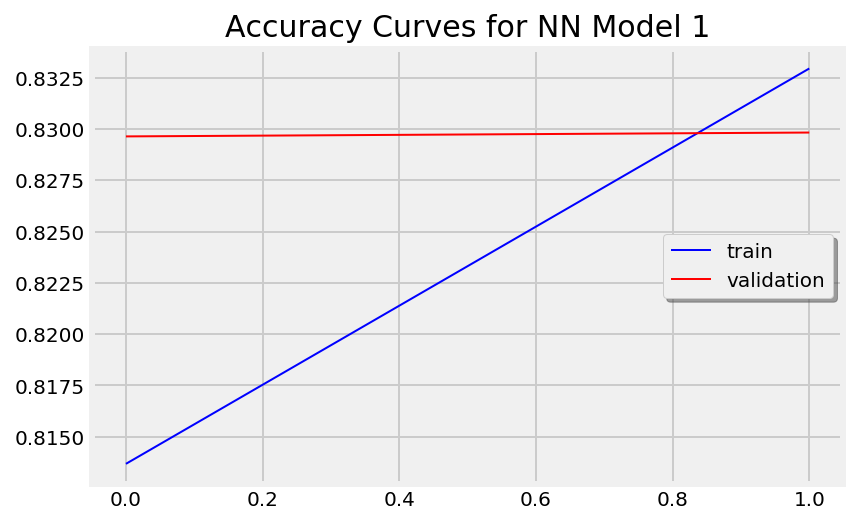

In [ ]:
# Plot the accuracy curves for training and validation 
plt.plot(history_nn1.history['acc'], color='b', label="train", linewidth = 1)
plt.plot(history_nn1.history['val_acc'], color='r',label="validation", linewidth = 1)
legend = plt.legend(loc='center right', shadow=True)
plt.title('Accuracy Curves for NN Model 1', fontsize = 15)
plt.savefig('model_nn1_acc_curves.png')

#### Accuracy Summary

In [ ]:
print('NN Model 1 Accuracy Summmary')
nn1_accuracy_summary = pd.DataFrame({
    'Model': ['NN 1'],
    'Learning Rate': [0.001],
    'Input Layer (Nodes)': ['1 (80,000)'],
    'Hidden Layer (Nodes)': ['1 (64 relu)'],
    'Output Layer (Nodes)': ['1 (1 sigmoid)'],
    'Training Accuracy': [round(train_acc_model_nn1, 3)],
    'Validation Accuracy': [round(val_acc_model_nn1, 3)]
    })

# nn1_accuracy_summary.to_csv('clf_compare_accuracy_summary.csv', index = False)
nn1_accuracy_summary

NN Model 1 Accuracy Summmary


,Model,Learning Rate,Input Layer (Nodes),Hidden Layer (Nodes),Output Layer (Nodes),Training Accuracy,Validation Accuracy
0,NN 1,0.001,"1 (80,000)",1 (64 relu),1 (1 sigmoid),0.844,0.83


### NN Model 2 (NN-2): with 20% dropout

#### Train Model

NN Model 2 includes a 20% dropout after the activiation layer. The purpose of the dropout layer is to reduce overfitting.

In [ ]:
%%time
model_nn2 = Sequential()
model_nn2.add(Dense(64, kernel_initializer ='uniform', activation='relu', input_dim=80000))
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(1, kernel_initializer ='uniform', activation='sigmoid'))

# compile model using accuracy to measure model performance
model_nn2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# define checkpoint to save model after each epoch
filepath = "model_nn2.h5"
nn2_checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='max', 
                                 period=1)

#train the model
history_nn2 = model_nn2.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32, callbacks=[nn2_checkpoint])

# # evaluate model on train & validation sets
# scores = model_nn2.evaluate(x_train_tfidf, y_train)
# print("\n%s: %.2f%%" % (model_nn2.metrics_names[1], scores[1]*100), "for training set\n")
# train_acc_model_nn2 = scores[1]

# scores_val = model_nn2.evaluate(x_validation_tfidf, y_validation)
# print("\n%s: %.2f%%" % (model_nn2.metrics_names[1], scores_val[1]*100), "for validation set")
# test_acc_model_nn2 = scores_val[1]

  ...
    to  
  ['...']
Train for 48878.75 steps, validate on 15960 samples
Epoch 1/2
48879/48878 [==============================] - 1345s 28ms/step - loss: 0.4108 - accuracy: 0.8134 - val_loss: 0.3900 - val_accuracy: 0.8294
Epoch 2/2
48879/48878 [==============================] - 1330s 27ms/step - loss: 0.3804 - accuracy: 0.8314 - val_loss: 0.3902 - val_accuracy: 0.8315
CPU times: user 2h 6min 13s, sys: 6min 46s, total: 2h 13min
Wall time: 44min 34s


NN-2 model training with 1 epoch was already completed using the script above. I will load the saved model ('model_nn2.h5') and continue training the model through the second epoch.

In [ ]:
# load model
model_nn2_load = load_model("model_nn2.h5")

# define checkpoint to save model after each epoch
filepath = "model_nn2.h5"
nn2_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', save_freq='epoch')

#train the model
history_nn2 = model_nn2_load.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=1, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32, callbacks=[nn2_checkpoint])

#### Evaluate Model

In [ ]:
# load model
model_nn2_load = load_model("model_nn2.h5")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
# evaluate model on train set
scores = model_nn2_load.evaluate(x_train_tfidf, y_train)
print("\n%s: %.2f%%" % (model_nn2_load.metrics_names[1], scores[1]*100), "for training set\n")
train_acc_model_nn2 = scores[1]

1564120/1564120 [==============================] - 789s 504us/step

acc: 83.84% for training set



In [ ]:
# evaluate model on validation set
scores_val = model_nn2_load.evaluate(x_validation_tfidf, y_validation)
print("\n%s: %.2f%%" % (model_nn2_load.metrics_names[1], scores_val[1]*100), "for validation set")
val_acc_model_nn2 = scores_val[1]

15960/15960 [==============================] - 7s 428us/step

acc: 82.87% for validation set


#### Plotting Accuracy Curves

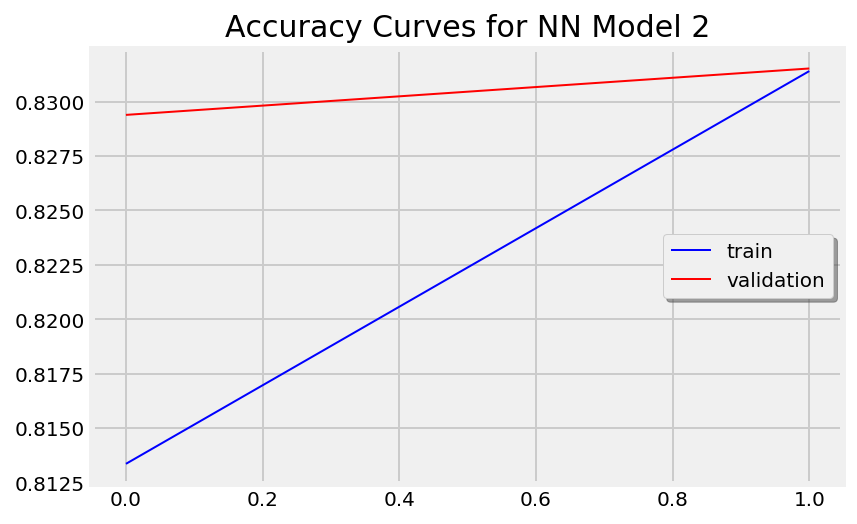

In [ ]:
# Plot the accuracy curves for training and validation 
plt.plot(history_nn2.history['acc'], color='b', label="train", linewidth = 1)
plt.plot(history_nn2.history['val_acc'], color='r',label="validation", linewidth = 1)
legend = plt.legend(loc='center right', shadow=True)
plt.title('Accuracy Curves for NN Model 2', fontsize = 15)
plt.savefig('model_nn2_acc_curves.png')

#### NN-2 Accuracy Summary

In [ ]:
print('NN Model 2 Accuracy Summmary')
nn2_accuracy_summary = pd.DataFrame({
    'Model': ['NN-2'],    
    'Learning Rate': [0.001],
    'Input Layer (Nodes)': ['1 (80,000)'],
    'Hidden Layer (Nodes)': ['1 (64 relu)'],
    'Output Layer (Nodes)': ['1 (1 sigmoid)'],
    'Training Accuracy': [round(train_acc_model_nn2, 3)],
    'Validation Accuracy': [round(test_acc_model_nn2, 3)]
    })

nn2_accuracy_summary.to_csv('nn2_accuracy_summary.csv', index = False)
nn2_accuracy_summary

NN Model 2 Accuracy Summmary


,Model,Learning Rate,Input Layer (Nodes),Hidden Layer (Nodes),Output Layer (Nodes),Training Accuracy,Validation Accuracy
0,NN-2,0.001,"1 (80,000)",1 (64 relu),1 (1 sigmoid),0.843,0.833


### NN Models Accuracy Summary

In [ ]:
nn_accuracy_summary = pd.concat(
    [nn1_accuracy_summary, 
     nn2_accuracy_summary])

nn_accuracy_summary.to_csv('nn_accuracy_summary.csv', index = False)
nn_accuracy_summary

,Model,Learning Rate,Input Layer (Nodes),Hidden Layer (Nodes),Output Layer (Nodes),Training Accuracy,Validation Accuracy
0,NN 1,0.001,"1 (80,000)",1 (64 relu),1 (1 sigmoid),0.845,0.831
0,NN-2,0.001,"1 (80,000)",1 (64 relu),1 (1 sigmoid),0.843,0.833


## CNN Models

1D Convoluational Neural Networks are are 

### Prepping Word Vectors for CNN Models

In [ ]:
import gensim.downloader as api
glove_twitter = api.load("glove-twitter-200")

[================================================--] 97.6% 740.3/758.5MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
len(glove_twitter.vocab.keys())

1193514

In [ ]:
embeddings_index = {}
for w in glove_twitter.vocab.keys():
    embeddings_index[w] = glove_twitter[w]
print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [ ]:
len(tokenizer.word_index)

261744

In [ ]:
for x in x_train[:5]:
    print(x)

run house but shit its taking me away from my homework ahhhh more classes more assignments
and we are having jaljeera party join in buddy fb
going out with friends tonight today is friends day
went paintballing yesterday got shot in the arm and it hurts but shot kid and he was cying in pain so its no all bad haha evil me
sorry ll make you chicken soup


In [ ]:
sequences[:5]

[[436, 204, 17, 353, 62, 408, 14, 212, 51, 3, 578, 1517, 79, 1138, 79, 2826],
 [5, 43, 33, 171, 14239, 269, 781, 9, 1232, 647],
 [42, 31, 20, 185, 116, 37, 8, 185, 29],
 [203,
  15929,
  278,
  45,
  1106,
  9,
  2,
  1486,
  5,
  4,
  340,
  17,
  1106,
  858,
  5,
  78,
  23,
  51053,
  9,
  494,
  15,
  62,
  35,
  30,
  110,
  97,
  1549,
  14],
 [115, 73, 119, 6, 870, 1449]]

In [ ]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [ ]:
max(length)

40

In [ ]:
x_train_seq = pad_sequences(sequences, maxlen=45)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1564120, 45)


In [ ]:
x_train_seq[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   436,   204,    17,   353,    62,   408,    14,
          212,    51,     3,   578,  1517,    79,  1138,    79,  2826],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     5,
           43,    33,   171, 14239,   269,   781,     9,  1232,   647],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
    

In [ ]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=45)

I am defining the number of words to be 100,000. This means I will only care about 100,000 most frequent words in the training set. If I don't limit the number of words, the total number of vocabulary will be more than 200,000.

In [ ]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

As a sanity check, if the embedding matrix has been generated properly. Above, when I saw the first five entries of the training set, the first entry started with the word "run," which had the sequential representation [436]. Let's see if the 436th embedding matrix is as same as vectors for the word 'run.'

In [ ]:
np.array_equal(embedding_matrix[436] ,embeddings_index.get('run'))

True

In [ ]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [ ]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 200)           20000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 100)           40100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


### CNN Model 1 (CNN-1)

CNN-1: Using static GloVe word vectors as input (trainable = False)

In [ ]:
%%time
model_cnn_1 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=False)
model_cnn_1.add(e)
model_cnn_1.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_1.add(GlobalMaxPooling1D())
model_cnn_1.add(Dense(256, activation='relu'))
model_cnn_1.add(Dense(1, activation='sigmoid'))
model_cnn_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define checkpoint to save model after each epoch
filepath = "model_cnn1.h5"
cnn1_checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='max', 
                                 period=1)

# running only 2 epochs for time-saving purposes
model_cnn_1.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=2, batch_size=32, verbose=1, callbacks=[cnn1_checkpoint])

Train on 1564120 samples, validate on 15960 samples
Epoch 1/2
1564120/1564120 [==============================] - 324s 207us/step - loss: 0.4195 - acc: 0.8065 - val_loss: 0.3966 - val_acc: 0.8232

Epoch 00001: val_acc improved from -inf to 0.82325, saving model to model_cnn1.h5
Epoch 2/2
1564120/1564120 [==============================] - 331s 212us/step - loss: 0.3976 - acc: 0.8192 - val_loss: 0.3962 - val_acc: 0.8242

Epoch 00002: val_acc improved from 0.82325 to 0.82419, saving model to model_cnn1.h5
CPU times: user 27min 15s, sys: 2min 8s, total: 29min 23s
Wall time: 10min 57s


Continue training CNN-1 model through 3 more epochs, for a total of 5 epochs.

In [ ]:
# load model only if restarting runtime session for this notebook
# model_cnn1_load = load_model("model_cnn1.h5")

# define checkpoint to save model after each epoch
filepath = "model_cnn1.h5"
cnn1_checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='max', 
                                 period=1)

# running only 2 epochs for time-saving purposes
model_cnn_1.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=3, batch_size=32, verbose=1, callbacks=[cnn1_checkpoint])

Train on 1564120 samples, validate on 15960 samples
Epoch 1/3
1564120/1564120 [==============================] - 326s 208us/step - loss: 0.3898 - acc: 0.8234 - val_loss: 0.3887 - val_acc: 0.8261

Epoch 00001: val_acc improved from -inf to 0.82607, saving model to model_cnn1.h5
Epoch 2/3
1564120/1564120 [==============================] - 320s 205us/step - loss: 0.3850 - acc: 0.8263 - val_loss: 0.3878 - val_acc: 0.8229

Epoch 00002: val_acc did not improve from 0.82607
Epoch 3/3
1564120/1564120 [==============================] - 324s 207us/step - loss: 0.3815 - acc: 0.8280 - val_loss: 0.3836 - val_acc: 0.8270

Epoch 00003: val_acc improved from 0.82607 to 0.82701, saving model to model_cnn1.h5


*  Best train accuracy score for CNN-1 is: 82.80%
*  Best val accuracy score for CNN-1 is 82.70%.

### CNN Model 2 (CNN-2)

CNN-2: Using GloVe word vectors as input and updating the vectors throughout the training process (trainable = True) 

In [ ]:
%%time
model_cnn_2 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)
model_cnn_2.add(e)
model_cnn_2.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_2.add(GlobalMaxPooling1D())
model_cnn_2.add(Dense(256, activation='relu'))
model_cnn_2.add(Dense(1, activation='sigmoid'))
model_cnn_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define checkpoint to save model after each epoch
filepath = "model_cnn2.h5"
cnn2_checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='max', 
                                 period=1)

# running only 1 epoch for time-saving purposes
model_cnn_2.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=1, batch_size=32, verbose=1, callbacks=[cnn2_checkpoint])









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1564120 samples, validate on 15960 samples
Epoch 1/1
1564120/1564120 [==============================] - 7251s 5ms/step - loss: 0.4010 - acc: 0.8171 - val_loss: 0.3718 - val_acc: 0.8352

Epoch 00001: val_acc improved from -inf to 0.83515, saving model to model_cnn2.h5
CPU times: user 6h 40min 4s, sys: 9min 46s, total: 6h 49min 50s
Wall time: 2h 52s


*  Best train accuracy score for CNN-2 is: 81.71%
*  Best val accuracy score for CNN-2 is 83.52%.

Continue training CNN-2 model through additional epochs to improve performance.

In [ ]:
# load model only if restarting runtime session for this notebook
# model_cnn_2_load = load_model("model_cnn2.h5")

# define checkpoint to save model after each epoch
filepath = "model_cnn2a.h5"
cnn2a_checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='max', 
                                 period=1)

# running only 1 epoch for time-saving purposes
model_cnn_2.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=1, batch_size=32, verbose=1, callbacks=[cnn2a_checkpoint])

Train on 1564120 samples, validate on 15960 samples
Epoch 1/1
1564120/1564120 [==============================] - 6967s 4ms/step - loss: 0.3526 - acc: 0.8447 - val_loss: 0.3697 - val_acc: 0.8368

Epoch 00001: val_acc improved from -inf to 0.83678, saving model to model_cnn2a.h5


*  Best train accuracy score for CNN-2a is: 84.47%
*  Best val accuracy score for CNN-2a is 83.68%.

## Final Models Evaluation

### Vectorizing Test Data

In [ ]:
x_test_tfidf = tfidf_vector.transform(x_test).toarray()

### TF-IDF + Logistic Regression

In [ ]:
lr_clf.score(x_test_tfidf, y_test)

0.8191216089217468

In [ ]:
print('TF-IDF Final Eval')
tfidf_lr_final_eval = pd.DataFrame({
    'Model': ['TF-IDF + LR'],    
    'Training Accuracy': ['83.57%'],
    'Validation Accuracy': ['83.13%'],
    'Test Accuracy': ['81.91%']
    })

# tfidf_lr_final_eval.to_csv('tfidf_lr_final_eval.csv', index = False)
tfidf_lr_final_eval

TF-IDF Final Eval


,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,TF-IDF + LR,83.57%,83.13%,81.91%


### NN Model 1 (NN-1)

In [ ]:
# load model
model_nn1_load = load_model("model_nn1.h5")

scores_test_nn1 = model_nn1_load.evaluate(x_test_tfidf, y_test)
print("\n%s: %.2f%%" % (model_nn1_load.metrics_names[1], scores_test_nn1[1]*100), "for test set\n")
test_acc_model_nn1 = scores_test_nn1[1]











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


15961/15961 [==============================] - 10s 640us/step

acc: 82.16% for test set



In [ ]:
print('NN-1 Final Evaluation')
nn1_final_eval = pd.DataFrame({
    'Model': ['NN-1'],    
    'Training Accuracy': ['84.42%'],
    'Validation Accuracy': ['82.98%'],
    'Test Accuracy': ['82.16%']
    })

# nn1_final_eval.to_csv('nn1_final_eval.csv', index = False)
nn1_final_eval

NN-1 Final Evaluation


,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,NN-1,84.42%,82.98%,82.16%


### NN Model 2 (NN-2)

In [ ]:
# load model if starting new runtime session
model_nn2_load = load_model("model_nn2.h5")

scores_test_nn2 = model_nn2_load.evaluate(x_test_tfidf, y_test)
print("\n%s: %.2f%%" % (model_nn2_load.metrics_names[1], scores_test_nn2[1]*100), "for test set\n")
test_acc_model_nn2 = scores_test_nn2[1]

15961/15961 [==============================] - 7s 432us/step

acc: 81.92% for test set



In [ ]:
# load model if starting new runtime session
model_nn2_load = load_model("model_nn2.h5")

scores_test_nn2 = model_nn2_load.evaluate(x_test_tfidf, y_test)
print("\n%s: %.2f%%" % (model_nn2_load.metrics_names[1], scores_test_nn2[1]*100), "for test set\n")
test_acc_model_nn2 = scores_test_nn2[1]

15961/15961 [==============================] - 7s 442us/step

acc: 83.84% for training set



In [ ]:
print('NN-2 Final Evaluation')
nn2_final_eval = pd.DataFrame({
    'Model': ['NN-2'],    
    'Training Accuracy': ['83.84%'],
    'Validation Accuracy': ['82.87%'],
    'Test Accuracy': ['81.92%']
    })

# nn2_final_eval.to_csv('nn2_final_eval.csv', index = False)
nn2_final_eval

NN-2 Final Evaluation


,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,NN-2,83.84%,82.87%,81.92%


### CNN Model 1 (CNN-1)

In [ ]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)

In [ ]:
# load model if starting new runtime session and update model name in evaluation
# model_cnn_1_load = load_model("model_cnn1.h5")

scores_test_cnn1 = model_cnn_1.evaluate(x_test_seq, y_test)
print("\n%s: %.2f%%" % (model_cnn_1.metrics_names[1], scores_test_cnn1[1]*100), "for test set\n")
test_acc_model_cnn1 = scores_test_cnn1[1]

15961/15961 [==============================] - 1s 77us/step

acc: 82.03% for test set



In [ ]:
print('CNN-1 Final Evaluation')
cnn1_final_eval = pd.DataFrame({
    'Model': ['CNN-1'],    
    'Training Accuracy': ['82.80%'],
    'Validation Accuracy': ['82.70%'],
    'Test Accuracy': ['82.03%']
    })

# cnn1_final_eval.to_csv('cnn1_final_eval.csv', index = False)
cnn1_final_eval

CNN-1 Final Evaluation


,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,CNN-1,82.80%,82.70%,82.03%


### CNN Model 2 (CNN-2)

In [ ]:
# load model if starting new runtime session
model_cnn_2_load = load_model("model_cnn2a.h5")

scores_test_cnn2a = model_cnn_2_load.evaluate(x_test_seq, y_test)
print("\n%s: %.2f%%" % (model_cnn_2_load.metrics_names[1], scores_test_cnn2a[1]*100), "for test set\n")
test_acc_model_cnn2a = scores_test_cnn2a[1]

15961/15961 [==============================] - 1s 89us/step

acc: 82.66% for test set



*  Best train accuracy score for CNN-2a is: 84.47%
*  Best val accuracy score for CNN-2a is 83.68%.

In [ ]:
print('CNN-2 Final Evaluation')
cnn2_final_eval = pd.DataFrame({
    'Model': ['CNN-2'],    
    'Training Accuracy': ['84.47%'],
    'Validation Accuracy': ['83.68%'],
    'Test Accuracy': ['82.66%']
    })

# cnn2_final_eval.to_csv('cnn2_final_eval.csv', index = False)
cnn2_final_eval

CNN-2 Final Evaluation


,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,CNN-2,84.47%,83.68%,82.66%


### Final Models Evaluation Summary

In [ ]:
print('Final Evaluation Summmary')
final_eval_summary = pd.concat(
    [tfidf_lr_final_eval,
     nn1_final_eval,
     nn2_final_eval,
     cnn1_final_eval,
     cnn2_final_eval])

final_eval_summary.to_csv('final_eval_summary.csv', index = False)
final_eval_summary

Final Evaluation Summmary


,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,TF-IDF + LR,83.57%,83.13%,81.91%
0,NN-1,84.42%,82.98%,82.16%
0,NN-2,83.84%,82.87%,81.92%
0,CNN-1,82.80%,82.70%,82.03%
0,CNN-2,84.47%,83.68%,82.66%


## AUC-ROC Curve on Best Models

The following plot shows the auc-roc curves of the top two models, NN-1 and CNN-2.

In [ ]:
# load NN-1 model
model_nn1_load = load_model("model_nn1.h5")

In [ ]:
yhat_nn1 = model_nn1_load.predict(x_test_tfidf)

In [ ]:
yhat_cnn2 = model_cnn_2_load.predict(x_test_seq)

In [ ]:
from sklearn.metrics import roc_curve, auc

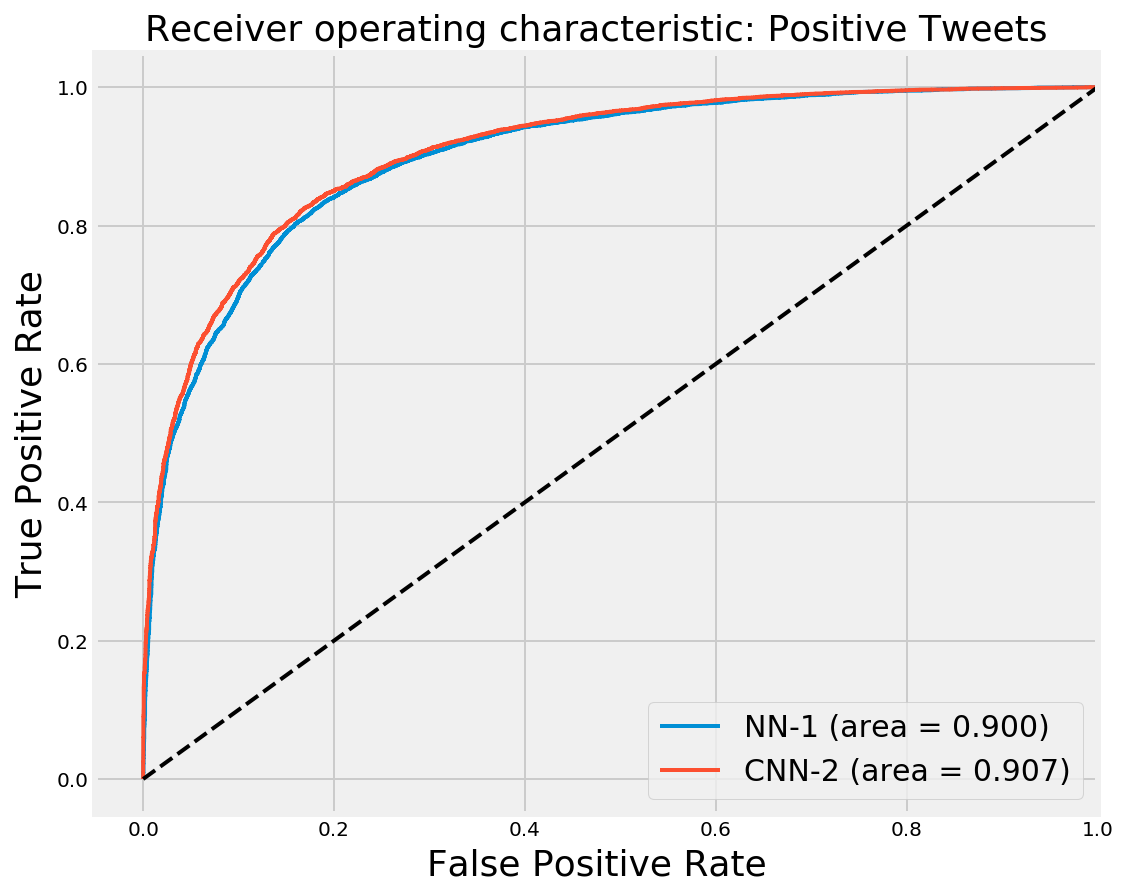

<Figure size 432x288 with 0 Axes>

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, yhat_nn1)
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn2)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='NN-1 (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='CNN-2 (area = %0.3f)' % roc_auc_cnn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: Positive Tweets', fontsize=18)
plt.legend(loc="lower right", fontsize=15)
plt.show()
plt.savefig('auc-roc_NNvsCNN.png')